In [1]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
pd.set_option('display.max_columns', 100)

/home/ubuntu/cbr360_plus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
curr_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(curr_dir,'Data')
model_dir = os.path.join(curr_dir,'Models')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
model_dir

'/home/ubuntu/cbr360_plus/Models'

In [4]:
prev_month = '2025-08-01'
current_month = '2025-09-01'

In [5]:
def read_data(model_date):
    filepath = f'KPIs_data_processed_{model_date}.csv'
    if not os.path.exists(os.path.join(data_dir, filepath)):
        import subprocess
        command = [
            "aws", "s3", "cp",
            f"s3://cbr-cohort-experiments/KPIs_Inference_Processed/{filepath}",
            "./Data/"
        ]
        
        subprocess.run(command, check=True)
    df = pd.read_csv(os.path.join(data_dir, filepath))
    return df
        

In [6]:
df_prev_full = read_data(prev_month)
df_curr_full = read_data(current_month)

df_prev_full.country.unique()

array(['Kenya', 'Myanmar (Burma)', 'Uganda', 'Nigeria', 'Tanzania',
       'India', 'Togo', 'Zambia', 'Mozambique', 'Cameroon', 'Malawi',
       'South Africa', 'Benin Republic'], dtype=object)

## Filters

In [7]:
uad = 360
accounts_group = '2024-05_Kenya_Lanterns_' #Keep the underscore at the end.

In [8]:
df_curr_full.backtesting_limit.unique()

array([ 30,  60,  90, 180, 270, 360])

In [9]:
df_curr_full_90 = df_curr_full[df_curr_full['backtesting_limit']==uad].copy()
df_curr_full_90.reset_index(drop=True, inplace=True)
print(df_curr_full_90.shape)
df_prev_full_90 = df_prev_full[df_prev_full['backtesting_limit']==uad].copy()
df_prev_full_90.reset_index(drop=True, inplace=True)
print(df_prev_full_90.shape)

(168594, 89)
(163845, 89)


In [10]:
df_curr = df_curr_full_90[df_curr_full_90['accounts_group'].str.contains(accounts_group)]
print(df_curr.shape)
df_prev = df_prev_full_90[df_prev_full_90['accounts_group'].str.contains(accounts_group)]
print(df_prev.shape)

(223, 89)
(223, 89)


In [15]:
df_curr.cohort_age_backtesting.unique()

array([450])

In [17]:
df_prev.cohort_age_backtesting.unique()

array([360])

In [ ]:
df_curr[df_curr.frr_450.notnull()]

In [19]:
df_curr.describe()

,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting
count,223.000000,223.000000,223.000000,2.230000e+02,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,0.0,0.0,0.0,221.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,0.0,0.0,0.0,223.000000,223.000000,222.000000,221.000000,221.000000,221.000000,221.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,0.0,0.0,0.0,223.0,2.230000e+02,223.000000,223.000000,223.0,223.000000,223.0,223.0
mean,433.417040,408.775785,27110.868002,3.504351e+06,26536.204958,0.064464,0.116700,0.165124,0.303259,0.434961,0.555522,0.662153,NaN,NaN,NaN,0.969042,0.830834,0.770143,0.695348,0.661240,0.631683,0.662102,NaN,NaN,NaN,2.728507,9.672646,17.811659,46.789238,77.937220,110.385650,144.134529,NaN,NaN,NaN,0.145989,0.056061,0.030330,0.014153,0.008066,0.006605,0.006808,NaN,NaN,NaN,0.020235,0.033399,0.053658,0.083116,0.122688,0.145815,0.178193,NaN,NaN,NaN,0.000044,0.000085,0.000267,0.000765,0.006987,0.012909,0.177803,NaN,NaN,NaN,0.257485,0.308244,0.329044,0.370185,0.419366,0.455354,0.457893,NaN,NaN,NaN,15.0,1.528500e+02,22926.730858,26536.204958,3.0,58.107623,360.0,450.0
std,490.174984,0.603254,30862.674635,3.989309e+06,30208.485389,0.017724,0.022635,0.028340,0.051390,0.085519,0.107464,0.129188,NaN,NaN,NaN,0.266498,0.161183,0.132227,0.117890,0.130046,0.122213,0.129190,NaN,NaN,NaN,1.659286,4.215535,6.556782,15.068775,24.043609,32.688734,42.674336,NaN,NaN,NaN,0.148020,0.121795,0.078938,0.070805,0.023620,0.020972,0.021686,NaN,NaN,NaN,0.074056,0.076033,0.101687,0.093092,0.129935,0.140671,0.162599,NaN,NaN,NaN,0.000225,0.000353,0.001256,0.001636,0.067137,0.068820,0.157388,NaN,NaN,NaN,0.165998,0.167049,0.176764,0.173848,0.184321,0.202192,0.205386,NaN,NaN,NaN,0.0,8.545695e-14,26099.505000,30208.485389,0.0,7.945597,0.0,0.0
min,1.000000,403.000000,47.114343,6.090000e+03,46.115670,0.002463,0.022989,0.032020,0.036946,0.036946,0.036946,0.036946,NaN,NaN,NaN,0.037000,0.163700,0.149400,0.084700,0.056100,0.042000,0.036900,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.000000,5.000000,5.000000,5.000000,

In [18]:
df_prev.describe()

,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting
count,223.000000,223.000000,223.000000,2.230000e+02,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,187.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,187.000000,0.0,0.0,0.0,221.000000,223.000000,223.000000,223.000000,223.000000,223.000000,183.000000,0.0,0.0,0.0,223.000000,223.000000,222.000000,221.000000,221.000000,221.000000,185.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,187.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,187.000000,0.0,0.0,0.0,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,187.000000,0.0,0.0,0.0,223.0,2.230000e+02,223.000000,223.000000,223.0,223.000000,223.0,223.0
mean,433.417040,408.784753,27109.010587,3.504382e+06,26536.439904,0.064463,0.116699,0.165123,0.303257,0.434958,0.555518,0.640777,NaN,NaN,NaN,0.969042,0.830834,0.770143,0.695348,0.661240,0.631685,0.640729,NaN,NaN,NaN,2.728507,9.672646,17.811659,46.789238,77.937220,110.385650,142.562842,NaN,NaN,NaN,0.145988,0.056061,0.030330,0.014152,0.008066,0.006605,0.005095,NaN,NaN,NaN,0.020235,0.033399,0.053658,0.083116,0.122694,0.145824,0.192497,NaN,NaN,NaN,0.000044,0.000085,0.000267,0.000765,0.006987,0.012909,0.183705,NaN,NaN,NaN,0.257485,0.308244,0.329047,0.370192,0.419373,0.455363,0.477104,NaN,NaN,NaN,14.0,1.528500e+02,22926.933848,26536.439904,3.0,58.107623,360.0,360.0
std,490.174984,0.599054,30860.453218,3.989331e+06,30208.648150,0.017724,0.022635,0.028340,0.051389,0.085519,0.107464,0.149606,NaN,NaN,NaN,0.266498,0.161183,0.132227,0.117890,0.130046,0.122213,0.149613,NaN,NaN,NaN,1.659286,4.215535,6.556782,15.068775,24.043609,32.688734,50.287253,NaN,NaN,NaN,0.148019,0.121795,0.078938,0.070805,0.023619,0.020972,0.012685,NaN,NaN,NaN,0.074056,0.076033,0.101687,0.093092,0.129939,0.140678,0.194091,NaN,NaN,NaN,0.000225,0.000353,0.001256,0.001636,0.067137,0.068820,0.194269,NaN,NaN,NaN,0.165998,0.167049,0.176766,0.173852,0.184325,0.202197,0.218241,NaN,NaN,NaN,0.0,8.545695e-14,26099.645623,30208.648150,0.0,7.945597,0.0,0.0
min,1.000000,403.000000,47.110698,6.090000e+03,46.115670,0.002463,0.022989,0.032020,0.036946,0.036946,0.036946,0.036946,NaN,NaN,NaN,0.037000,0.163700,0.149400,0.084700,0.056100,0.042000,0.036900,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.000000,5.000000,5.000000,0.000000,

## Summary Stats

In [22]:
uad2 = uad + 90
cols = [f'frr_{uad2}',f'repayment_speed_{uad2}',f'at_risk_rate_{uad2}',f'disabled_gt_two_week_rate_{uad2}',f'disabled_rate_{uad2}',
       'avg_upfront_price_usd', 'avg_unlock_price_usd', 'avg_planned_repayment_days', f'unlocked_rate_{uad2}']

In [23]:
df_curr[cols].describe()

,frr_450,repayment_speed_450,at_risk_rate_450,disabled_gt_two_week_rate_450,disabled_rate_450,avg_upfront_price_usd,avg_unlock_price_usd,avg_planned_repayment_days,unlocked_rate_450
count,223.000000,223.000000,221.000000,223.000000,223.000000,223.0,223.000000,223.000000,223.000000
mean,0.662153,0.662102,0.006808,0.178193,0.457893,3.0,58.107623,408.775785,0.177803
std,0.129188,0.129190,0.021686,0.162599,0.205386,0.0,7.945597,0.603254,0.157388
min,0.036946,0.036900,0.000000,0.000000,0.000000,3.0,48.000000,403.000000,0.000000
25%,0.621519,0.621500,0.000000,0.115690,0.393157,3.0,49.000000,409.000000,0.115615
50%,0.661723,0.661700,0.001946,0.155904,0.465753,3.0,65.000000,409.000000,0.153846
75%,0.707628,0.707600,0.006098,0.198220,0.523256,3.0,65.000000,409.000000,0.210877
max,1.000000,1.000000,0.250000,1.000000,1.000000,3.0,65.000000,411.000000,1.000000


In [24]:
df_prev[cols].describe()

,frr_450,repayment_speed_450,at_risk_rate_450,disabled_gt_two_week_rate_450,disabled_rate_450,avg_upfront_price_usd,avg_unlock_price_usd,avg_planned_repayment_days,unlocked_rate_450
count,187.000000,187.000000,185.000000,187.000000,187.000000,223.0,223.000000,223.000000,187.000000
mean,0.640777,0.640729,0.005095,0.192497,0.477104,3.0,58.107623,408.784753,0.183705
std,0.149606,0.149613,0.012685,0.194091,0.218241,0.0,7.945597,0.599054,0.194269
min,0.036946,0.036900,0.000000,0.000000,0.000000,3.0,48.000000,403.000000,0.000000
25%,0.598329,0.598250,0.000000,0.099223,0.405263,3.0,49.000000,409.000000,0.101020
50%,0.650161,0.650100,0.000000,0.160622,0.487047,3.0,65.000000,409.000000,0.143969
75%,0.705389,0.705350,0.007576,0.214095,0.546473,3.0,65.000000,409.000000,0.194906
max,1.000000,1.000000,0.111111,1.000000,1.000000,3.0,65.000000,411.000000,1.000000


In [29]:
df_prev.backtesting_limit.unique()

array([360])

In [27]:
df_prev[df_prev.cohort_age_backtesting=='450']

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting


In [16]:
set(df_curr.accounts_group) - set(df_prev.accounts_group)

set()

In [17]:
df_curr.shape

(223, 89)

In [18]:
# diff = pd.concat([df_curr, df_prev]).drop_duplicates(keep=False)

In [19]:
def fetch_models(model_filename):
    if not os.path.exists(os.path.join(model_dir, model_filename)):
        import subprocess
        command = [
            "aws", "s3", "cp",
            f"s3://cbr-cohort-experiments/Models/{model_filename}",
            "./Models/"
        ]
        
        subprocess.run(command, check=True)
    return os.path.join(model_dir, model_filename)

In [20]:
models = [
      "--model_file_30_1",
      "quantile_regression_30_0.1_days_2023-10-16.txt",
      "--model_file_30_5",
      "quantile_regression_30_0.5_days_2023-10-16.txt",
      "--model_file_30_8",
      "quantile_regression_30_0.8_days_2023-10-16.txt",
      "--model_file_60_1",
      "quantile_regression_60_0.1_days_2023-10-16.txt",
      "--model_file_60_5",
      "quantile_regression_60_0.5_days_2023-10-16.txt",
      "--model_file_60_8",
      "quantile_regression_60_0.8_days_2023-10-16.txt",
      "--model_file_90_1",
      "quantile_regression_90_0.1_days_2024-03-20.txt",
      "--model_file_90_5",
      "quantile_regression_90_0.5_days_2025-02-23.txt",
      "--model_file_90_8",
      "quantile_regression_90_0.8_days_2024-03-20.txt",
      "--model_file_180_1",
      "quantile_regression_180_0.1_days_2023-09-28.txt",
      "--model_file_180_5",
      "quantile_regression_180_0.5_days_2025-02-23.txt",
      "--model_file_180_8",
      "quantile_regression_180_0.8_days_2023-09-28.txt",
      "--model_file_270_1",
      "quantile_regression_270_0.1_days_2024-03-19.txt",
      "--model_file_270_5",
      "quantile_regression_270_0.5_days_2025-02-23.txt",
      "--model_file_270_8",
      "quantile_regression_270_0.8_days_2024-03-19.txt",
      "--model_file_360_1",
      "quantile_regression_360+_0.1_days_2024-03-19.txt",
      "--model_file_360_5",
      "quantile_regression_360_0.5_days_2025-02-23.txt",
      "--model_file_360_8",
      "quantile_regression_360+_0.8_days_2024-03-19.txt"
    ]
models_clean = [i for i in models if i.startswith("quantile_") and "_0.5_" in i]
models_clean 

['quantile_regression_30_0.5_days_2023-10-16.txt',
 'quantile_regression_60_0.5_days_2023-10-16.txt',
 'quantile_regression_90_0.5_days_2025-02-23.txt',
 'quantile_regression_180_0.5_days_2025-02-23.txt',
 'quantile_regression_270_0.5_days_2025-02-23.txt',
 'quantile_regression_360_0.5_days_2025-02-23.txt']

In [21]:
model_file = [i for i in models_clean if str(uad) in i]
model_path = fetch_models(model_file[0])

In [36]:
model = lightgbm.Booster(model_file = model_path)
feature_cols = model.feature_name()

## LGBM Feature Importance

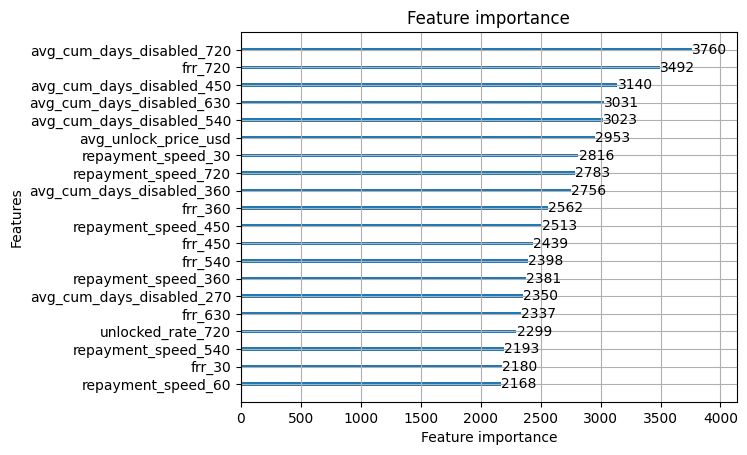

In [37]:
from lightgbm import LGBMRegressor, plot_importance
plot_importance(model, max_num_features=20)
plt.show()

In [38]:
X_prev = df_prev[feature_cols]
X_curr = df_curr[feature_cols]

In [39]:
explainer = shap.TreeExplainer(model)

shap_values_prev = explainer.shap_values(X_prev)
shap_values_curr = explainer.shap_values(X_curr)

In [40]:
df_shap_values_prev = pd.DataFrame(shap_values_prev, columns = X_prev.columns)
df_shap_values_curr = pd.DataFrame(shap_values_curr, columns = X_curr.columns)

In [41]:
comb_impact_per_row_prev = df_shap_values_prev.sum(axis=1)
comb_impact_per_row_curr = df_shap_values_curr.sum(axis=1)

# Calculating median impact of all features for the entire cohort
print('Median combined impact of all features in Previous: ',comb_impact_per_row_prev.median())
print('Median combined impact of all features in Current Mont: ',comb_impact_per_row_curr.median())

Median combined impact of all features in Previous:  0.029308751691744003
Median combined impact of all features in Current Mont:  0.03485103526089942


In [42]:
df_shap_values = pd.DataFrame(df_shap_values_prev.median().values, index=df_shap_values_curr.columns, columns=['Prev'])
df_shap_values['Curr'] = df_shap_values_curr.median().values
df_shap_values['diff'] = df_shap_values['Prev'] - df_shap_values['Curr']

df_shap_values.sort_values(by='diff', ascending=False).round(4)

,Prev,Curr,diff
repayment_speed_450,-0.0249,-0.0254,0.0005
disabled_gt_two_week_rate_180,0.0022,0.0021,0.0001
disabled_gt_two_week_rate_270,0.0034,0.0033,0.0001
at_risk_rate_90,0.0013,0.0012,0.0001
disabled_rate_270,-0.0010,-0.0011,0.0001
...,...,...,...
repayment_speed_720,0.0046,0.0053,-0.0007
disabled_gt_two_week_rate_540,0.0065,0.0073,-0.0007
frr_720,0.0016,0.0025,-0.0008
frr_450,0.0049,0.0059,-0.0010


In [43]:
df_shap_values_mean = pd.DataFrame(df_shap_values_prev.mean().values, index=df_shap_values_curr.columns, columns=['Prev'])
df_shap_values_mean['Curr'] = df_shap_values_curr.mean().values
df_shap_values_mean['diff'] = df_shap_values_mean['Prev'] - df_shap_values_mean['Curr']

df_shap_values_mean.sort_values(by='diff', ascending=False).round(4)

,Prev,Curr,diff
repayment_speed_450,-0.0214,-0.0233,0.0020
disabled_gt_two_week_rate_360,0.0025,0.0024,0.0001
disabled_rate_450,0.0002,0.0001,0.0001
repayment_speed_180,0.0004,0.0003,0.0001
at_risk_rate_90,0.0010,0.0009,0.0001
...,...,...,...
at_risk_rate_450,0.0002,0.0007,-0.0005
repayment_speed_720,0.0039,0.0045,-0.0006
frr_720,0.0007,0.0016,-0.0009
avg_cum_days_disabled_450,0.0003,0.0021,-0.0018


## SHAP Summary Plot Prev and Current

/home/ubuntu/cbr360_plus/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


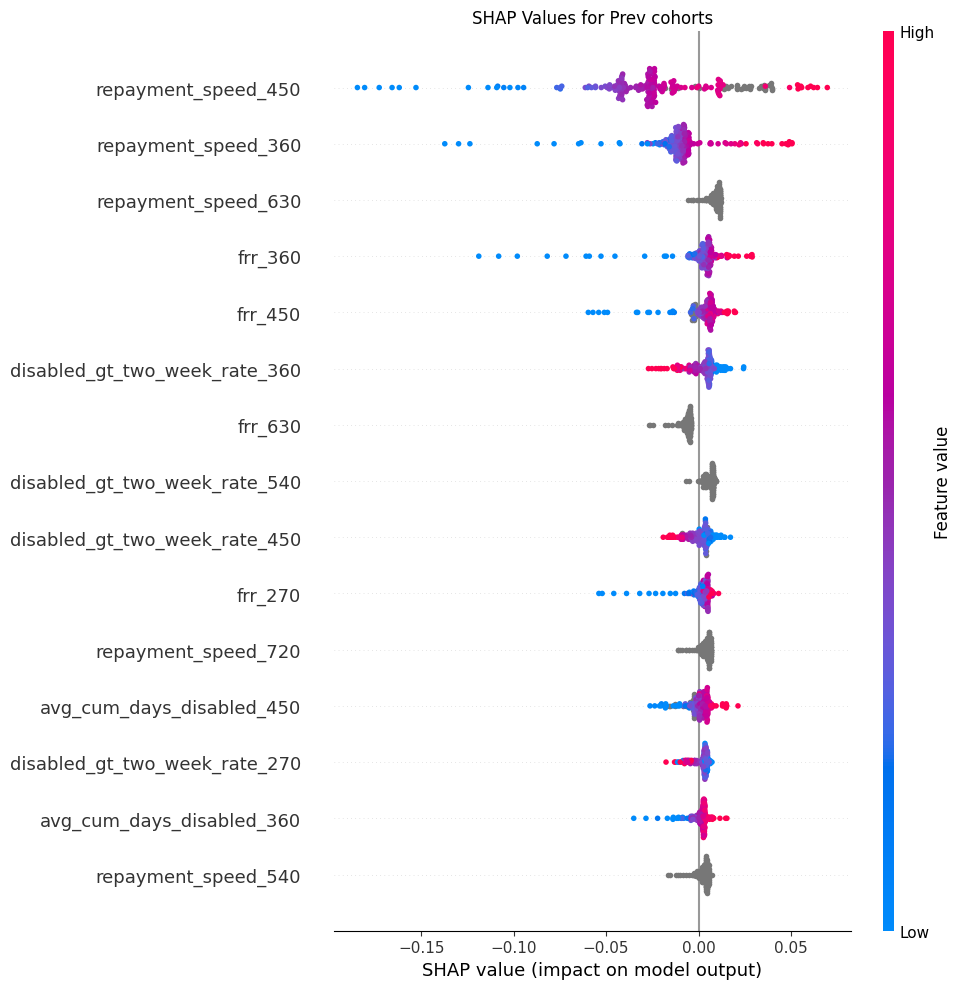

In [51]:
explainer = shap.TreeExplainer(model)
shap_values_prev = explainer.shap_values(X_prev)
plt.title('SHAP Values for Prev cohorts')
shap.summary_plot(shap_values_prev, X_prev, max_display=15,plot_size=(10,10),)
plt.show()

/home/ubuntu/cbr360_plus/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


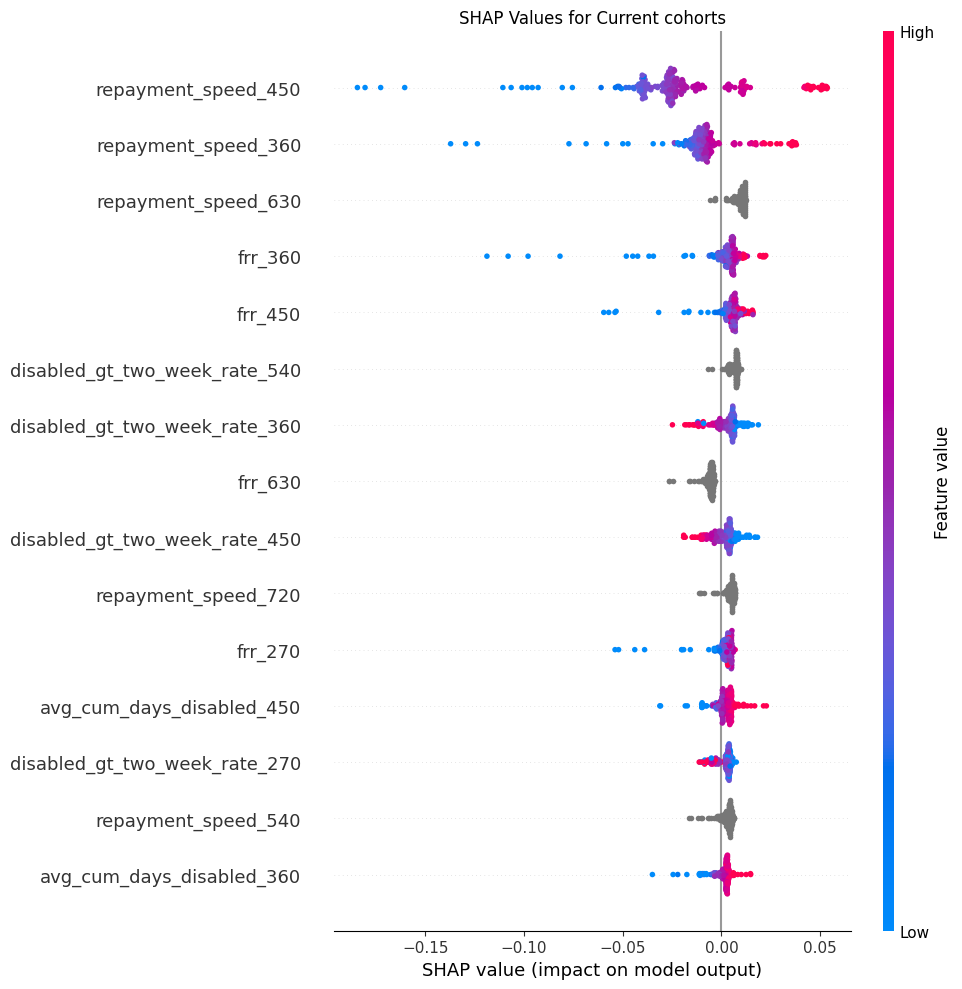

In [52]:
explainer = shap.TreeExplainer(model)
shap_values_curr = explainer.shap_values(X_curr)
plt.title('SHAP Values for Current cohorts')
shap.summary_plot(shap_values_curr, X_curr, max_display=15,plot_size=(10,10),)
plt.show()

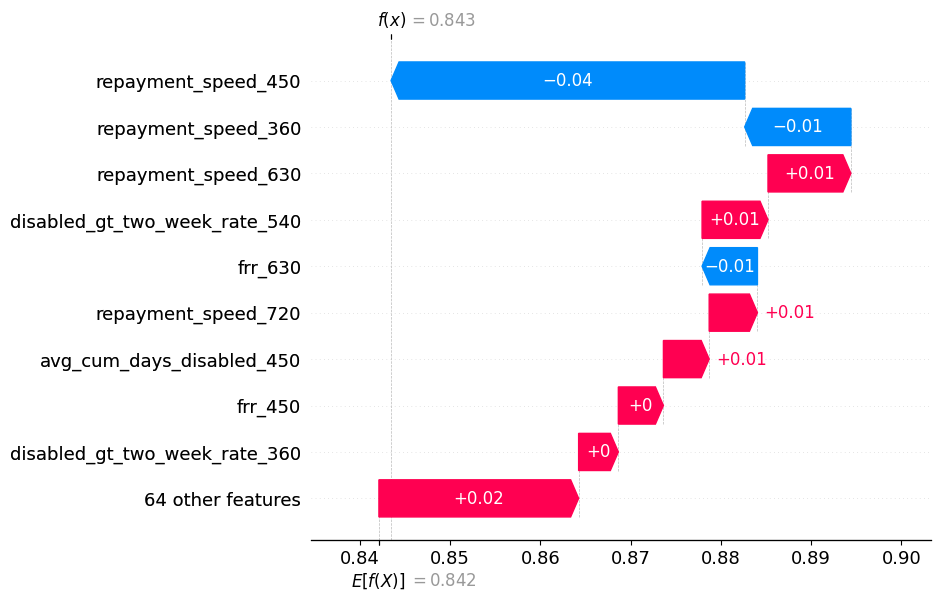

In [46]:
# Get shap values for the first sample
shap_values_X = explainer.shap_values(X_curr) 
shap_values = shap_values_X[2]  # shape: (n_features,)
list_columns = X_curr.columns.tolist() 
features = shap_values_X.flatten()

# Plot waterfall
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, 
    shap_values, 
    feature_names=list_columns, 
    max_display=10
)

In [36]:
X_curr.shape

(223, 73)

In [37]:
X_prev.shape

(223, 73)

# Analyse Performance of Added or Removed Cohort

In [ ]:
diffs = set(df_curr.accounts_group) ^ set(df_prev.accounts_group)
diffs

In [ ]:
set(df_curr.accounts_group) - set(df_prev.accounts_group)

In [ ]:
set(df_prev.accounts_group) - set(df_curr.accounts_group)

In [ ]:
a = df_curr[df_curr.accounts_group.isin(list(diffs))]
a[feature_cols]

In [ ]:
# 1. Select the row (assume only one row after filtering)
X_point = a[feature_cols]

# 2. Get shap values for this point
shap_values_point = explainer.shap_values(X_point)[0]  # (n_features,)

# 3. Build Explanation object
exp = shap.Explanation(
    values=shap_values_point,
    base_values=explainer.expected_value,
    data=X_point.iloc[0],              # feature values
    feature_names=feature_cols
)

# 4. Plot waterfall
shap.plots.waterfall(exp, max_display=10)